## Index a Wikipedia dump file
Ingests a Wikipedia dump and creates several SQL databases:
 - `index`: maps page number to the title, start and end indices, and raw coord tag
 - `coords`: maps page number to lots of attributes in a coord tag
 - `title`: maps page title to page number
 
Here's an example of a coord tag from a Wikipedia article:
```
coord|42.440556|-98.148083|type:landmark|name=Ashfall Fossil Beds
```

In [1]:
from wikiparse import geo_indexer
from pathlib import Path

In [2]:
xml_filename = "wiki_sample.xml"
scratch_folder = Path("scratch-pipeline")

In [3]:
indexer = geo_indexer.Indexer(xml_filename,
            scratch_folder=scratch_folder)
indexer.load()

opening scratch-pipeline\index.db
Ready. Metadata: [('size', 999)]
iterating 100.0% of pages took 0.01 minutes
100.0 % contained coordinates tag
Creating title dictionary


## Compute most common words across all pages we're considering
We need to know the frequency of words across all pages in our set (which is pages with coordinate tags). This can be parallelized.
 - new document freq.ipynb

In [4]:
from wikiparse import tokenize

In [5]:
# tokenize.create_doc_freq(indexer, scratch_folder)

## Do TF-IDF
Gets each page and creates a list of all the words that occur in it, and their TF-IDF / significance score. Save the top 30 most significant words for each page.

In [6]:
# tokenize.create_tfidf(indexer, scratch_folder)

## Make a GeoDataFrame

In [7]:
from pandas import read_csv

In [8]:
df = read_csv(scratch_folder/'tfidf.csv', names=['idx', 'word', 'tf', 'article', 'df', 'tf_idf'])
del df['idx']

In [9]:
df.sample(5)

,word,tf,article,df,tf_idf
12234,counties,1,"Khalilabad, Markazi",207,0.004830917874396135
46358,lying,1,Aeolus Ridge,19,0.05263157894736842
5838,65,5,"Charter Oak, Iowa",76,0.06578947368421052
18132,walk,1,Robert Martin (aviator),11,0.09090909090909093
21788,versus,1,"Zumbrota Township, Goodhue County, Minnesota",31,0.03225806451612903


In [10]:
from wikiparse import pipeline_utils as utils

In [11]:
gdf = utils.make_gdf(df, indexer)

getting lat,lon for each article
took 0.005 minutes
making geom vector
took 0.0 minutes
creating geodataframe


In [12]:
gdf.sample(5)

,word,tf,article,df,tf_idf,geometry
18010,2009a,1,South Salem Covered Bridge,14,0.07142857142857142,POINT (-83.31444 39.33417)
27511,edt,1,"Joyland, Lexington",33,0.030303030303030307,POINT (-84.45700 38.08800)
1294,of,20,Pravdinsky District,990,0.020202020202020204,POINT (21.01667 54.45000)
46709,protected,5,Keheliya Raja Maha Vihara,31,0.16129032258064516,POINT (81.12706 6.66550)
43570,18,1,Şahlıq,237,0.004219409282700422,POINT (47.49000 40.47167)


In [13]:
gdf.to_pickle(scratch_folder/'gdf.pkl')

## Make some maps

In [14]:
import geopandas

In [15]:
sample_size = min(len(gdf),100_000)

In [16]:
%matplotlib inline

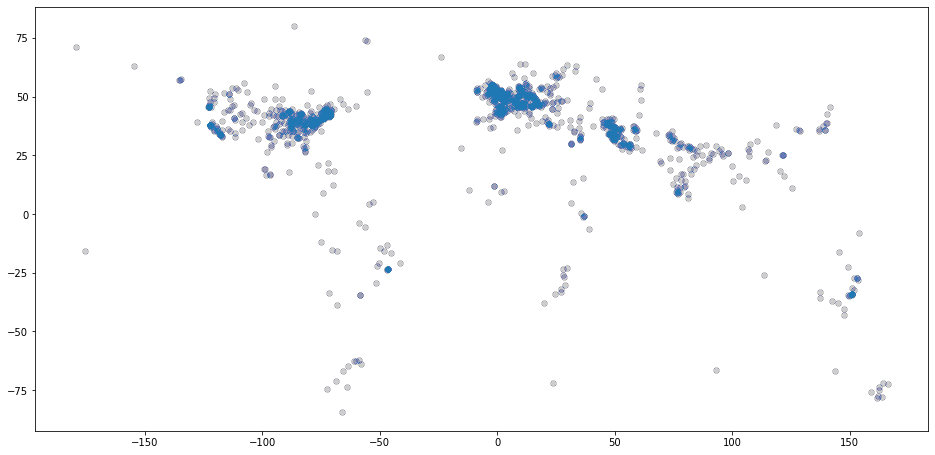

In [17]:
gdf.sample(sample_size).plot(figsize=(16,12), alpha=0.005)

ImportError: The descartes package is required for plotting polygons in geopandas. You can install it using 'conda install -c conda-forge descartes' or 'pip install descartes'.

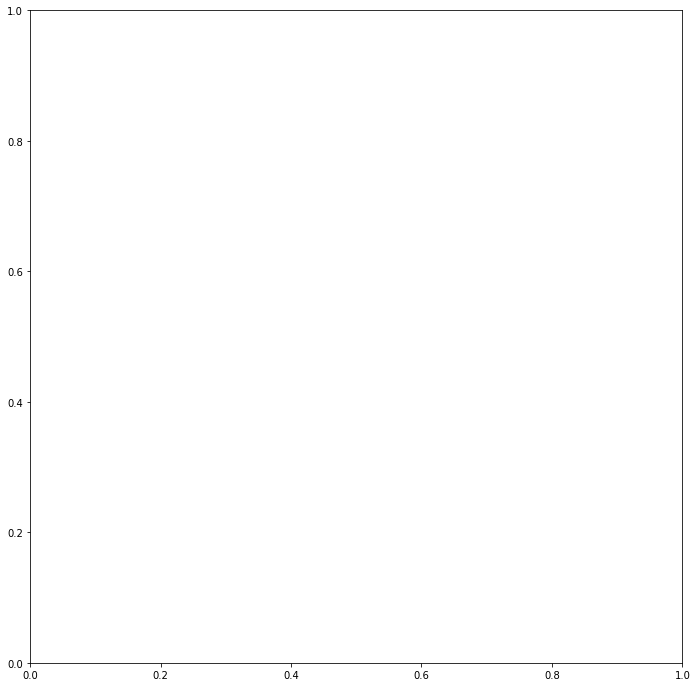

In [18]:
utils.map_gdf(gdf.sample(sample_size), alpha=0.01, markersize=1, c='g')

## Some data analysis

What are the most commonly occuring words in our dataset?

In [ ]:
!conda install -c conda-forge descartes

In [20]:
gdf.groupby(by='word').count().sort_values('article', ascending=False).article[:20]

word
of                   295
the                  289
county               167
district             164
ref                  141
in                   140
village              137
census               124
province             122
2006                 100
populated             99
districts             92
subdivision_name4     91
provinces             90
subdivision_name3     90
countries             89
subdivision_type3     89
flag                  89
rural                 88
subdivision_type4     88
Name: article, dtype: int64